In [ ]:
sfrom collections import defaultdict
import matplotlib.pyplot as plt
import random
import gym
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import linear_model
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from scipy.stats import ortho_group 
from scipy.linalg import hadamard

In [ ]:
def initialize(ep_max_step,game):
    #ep_max_step: number of action
    env = gym.make(game).env
    env.reset()
    out =[]
    for i in range(ep_max_step):
        out.append(env.action_space.sample())
    return out # return a serie of action, length = ep_max_step


# used for generate Z
def orthogonal_mat(size):
    return ortho_group.rvs(dim=size)

def rotation(R):
#     R is the matrix. 
    I = 10
    J = 10
    theta = random.uniform(0, 2*np.pi)
    for i in range(I):
        for j in range(J):
            if i == j and i != I-1 and i != J-1:
                R[i,j] = 1
            if i != j and i != I-1 and j != J-1:
                R[i,j] = 0
            if i == j and i == I or i == J:
                R[i,j] = np.cos(theta)
            if i == J and j == I:
                R[i,j] = np.sin(theta)
            if i == I and j == J:
                R[i,j] = - np.sin(theta)
    return R



def generate_Z(Z,method,ep_max_step):
    '''
    N: number of kids
    method: control variate mechanism (vanilla, antithetic, FD-forward)
    '''

    if method == "vanilla":
        Z = Z
    elif method == "FD-forward":
        Z_A = Z[:, 0: int(ep_max_step/2)]
        Z_B = np.zeros(np.shape(Z_A))
        Z = np.concatenate((Z_A, Z_B),axis=1)
    elif method == "antithetic":
        Z_A = Z[:,0:int(ep_max_step/2)]
        Z_B = - Z_A
        Z = np.concatenate((Z_A, Z_B),axis=1)
    else:
        print("method not available.")
        return  
    return Z

    
def convertToAction(x, min_action, max_action):
    '''
    Input:
                 x:  perturbed action
        min_action:  minimum value of current action space
        max_action:  maximum value of current action space
                th:  default threshold for perturbation
        
    Output:
        Converted legible action(discrete)
    '''
    
    if x < (min_action):
        result = min_action
    elif x > (max_action):
        result = max_action
    else:
        result = round(x)
        
    return result   
    
    
def activation(A,Z,game,epi,ep_max_step,N):
    
    #A:     original serie of action
    #Z:     guassian smoothed noisy directions
    #game:  name of the game
    #epi:   coefficient
    
    #return a serie of action for each kid, (num_kid,num_action), 2d

    #     if deviation > 0 and at 0, perturb from 0 to 1. if deviation < 0 and at 1, perturb from 1 to 0.
    
    vfunc = np.vectorize(convertToAction)     # Vectorize a function
    env = gym.make(game)
    space = env.action_space.n
    action_space = np.arange(space)
    final_a = np.zeros((N, ep_max_step), dtype=int)
    for row in range(N):
        perturbation = Z[row]
        perturbed_a  = perturbation*epi + A
        final_a[row, :] = vfunc(perturbed_a, action_space[0], action_space[-1]).astype('int32')
    return final_a

def get_reward(A,game):
    #A: a serie of action, 1-D array
    #game: name of the game
    env = gym.make(game).env
    env.seed(0)
    s = env.reset()
    ep_r = 0.
    for a in A:
        s, r, done, _ = env.step(a)
        # mountain car's reward can be tricky
        if game == 'MountainCar' and s[0] > -0.1: r = 0.
        ep_r += r
        if done: 
            break
    env.close()
    return ep_r #return the score of that action in the game, type int

def regression(scores,A,method):
    #scores: a list of score for each serie of each element in A
    #A: a list of series of action, 2d
    #method: regression method ("lasso", "ridge", "lp-decoding")
    alpha1=0.05       # coefficient for regression
    if method == "lasso":
        model = linear_model.Lasso(alpha1)
        model.fit(A, scores)
        v = model.coef_ 
    elif method == "ridge":
        model = linear_model.Ridge(alpha1)
        model.fit(A, scores)
        v = model.coef_ 
    elif method == "lp-decoding":
        model = linear_model.LinearRegression()
        model.fit(A, scores)
        v = model.coef_ 
    else:
        print("method not available.")
        return  

    return v # return the gradiant, a list of float, length = len(A)[0]

def get_new_action(grad,A,alpha, game):
    #grad: gradiant at location A
    #A: the original action set
    #alpha: coefficient for new action
    env = gym.make(game)
    space = env.action_space.n
    action_space = np.arange(space)           # all possible actions
    new = A+grad*alpha
    vfunc  = np.vectorize(convertToAction)     # Vectorize a function
    newA = vfunc(new, action_space[0], action_space[-1])
    newA = newA.astype('int64')

    return newA  #return a new serie of actions


def main():
    num_iteration = 200                       #number of iteration
    num_kid = 100                             #number of sampling in each iteration
    epi = 0.16                                #epi is the coefficient for 
    CONFIG = [
    dict(game="CartPole-v0",
         n_feature=4, n_action=2, continuous_a=[False], ep_max_step=512, eval_threshold=400),
    dict(game="MountainCar-v0",
         n_feature=2, n_action=3, continuous_a=[False], ep_max_step=200, eval_threshold=-120),
    dict(game="Pendulum-v1",
         n_feature=3, n_action=1, continuous_a=[True, 2.], ep_max_step=200, eval_threshold=-180)
][0] #choice game here

    control_var = ['vanilla','FD-forward','antithetic']
    regression_method = ['lasso','ridge','lp-decoding']
    MC = ['Hadamard matrices','Gaussian orthogonal','random','rotation']
    outcome = defaultdict(list)               #use a defaultdict to store the reward of each iteration
    for i in control_var:
        for j in regression_method:
            for k in MC:
                A = initialize(CONFIG['ep_max_step'],CONFIG['game'])  #randomly initiate a sequence of actions
                outcome[(i,j,k)].append(get_reward(A,CONFIG['game']))
                for x in range(num_iteration):
                    print(f"This is iteration {x} -----------------------------")
                    if k == 'Hadamard matrices':   # select num_kid numbers of rows from a hadamard matrix
                        hm = (hadamard(CONFIG['ep_max_step'])) * np.random.randn(CONFIG['ep_max_step'])*1.3
                        index = np.random.choice(np.shape(hm)[0],num_kid)
                        Z = hm[index, :]
                    elif k == 'Gaussian orthogonal':   # select num_kid numbers of rows from a orthogonal matrix
                        go = orthogonal_mat(CONFIG['ep_max_step'])/epi*4
                        index = np.random.choice(np.shape(go)[0],num_kid)
                        Z = go[index, :]
                    elif k == 'rotation':  # select num_kid numbers of rows from a rotation matrix
                        hm = (hadamard(CONFIG['ep_max_step'])) * np.random.randn(CONFIG['ep_max_step'])*1.3
                        ro = rotation(hm)
                        index = np.random.choice(np.shape(ro)[0],num_kid)
                        Z = ro[index, :]
                    else: # randomly choose from multivariate normal distribution with mean = 0, var = I
                        Z = np.random.multivariate_normal(np.zeros(CONFIG['ep_max_step']),np.eye(CONFIG['ep_max_step']),num_kid)
                    Z = generate_Z(Z,i,CONFIG['ep_max_step'])
                    new_As = activation(A,Z,CONFIG['game'],epi,CONFIG['ep_max_step'],num_kid) #perturbed actions
                    sub_score = []
                    for a in range(len(new_As)):  #get reward for each perturbed action.
                        reward = get_reward(new_As[a],CONFIG['game'])
                        sub_score.append(reward)
                    grad = regression(sub_score,new_As,j) #get the gradient of perturbed action
                    try:
                        A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
                    except ValueError: #the perturbed actions may have too little variance so that the reward is unchanged
                        continue
                    outcome[(i,j,k)].append(get_reward(A,CONFIG['game']))
                    print(outcome[i,j,k][-1])
    return A,outcome
    
A,outcome = main()
            
                
                
        
        

This is iteration 0 -----------------------------
15.0
This is iteration 1 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 2 -----------------------------
This is iteration 3 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 4 -----------------------------
This is iteration 5 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 6 -----------------------------
This is iteration 7 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 8 -----------------------------
20.0
This is iteration 9 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 10 -----------------------------
This is iteration 11 -----------------------------
26.0
This is iteration 12 -----------------------------
This is iteration 13 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 14 -----------------------------
This is iteration 15 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


36.0
This is iteration 16 -----------------------------
This is iteration 17 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 18 -----------------------------
This is iteration 19 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


49.0
This is iteration 20 -----------------------------
This is iteration 21 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 22 -----------------------------
49.0
This is iteration 23 -----------------------------
49.0
This is iteration 24 -----------------------------
This is iteration 25 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 26 -----------------------------
This is iteration 27 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 28 -----------------------------
49.0
This is iteration 29 -----------------------------
49.0
This is iteration 30 -----------------------------
This is iteration 31 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 32 -----------------------------
This is iteration 33 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 34 -----------------------------
49.0
This is iteration 35 -----------------------------
71.0
This is iteration 36 -----------------------------
71.0
This is iteration 37 -----------------------------
89.0
This is iteration 38 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 39 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 40 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 41 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 42 -----------------------------
89.0
This is iteration 43 -----------------------------
This is iteration 44 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 45 -----------------------------
89.0
This is iteration 46 -----------------------------
89.0
This is iteration 47 -----------------------------
89.0
This is iteration 48 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 49 -----------------------------
74.0
This is iteration 50 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 51 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 52 -----------------------------
74.0
This is iteration 53 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 54 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 55 -----------------------------
74.0
This is iteration 56 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 57 -----------------------------
84.0
This is iteration 58 -----------------------------
84.0
This is iteration 59 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 60 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 61 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 62 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 63 -----------------------------
This is iteration 64 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 65 -----------------------------
84.0
This is iteration 66 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 67 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 68 -----------------------------
84.0
This is iteration 69 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 70 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 71 -----------------------------
84.0
This is iteration 72 -----------------------------
91.0
This is iteration 73 -----------------------------
91.0
This is iteration 74 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 75 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


91.0
This is iteration 76 -----------------------------
This is iteration 77 -----------------------------
This is iteration 78 -----------------------------
91.0
This is iteration 79 -----------------------------
This is iteration 80 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


91.0
This is iteration 81 -----------------------------
91.0
This is iteration 82 -----------------------------
91.0
This is iteration 83 -----------------------------
This is iteration 84 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 85 -----------------------------
91.0
This is iteration 86 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 87 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 88 -----------------------------
91.0
This is iteration 89 -----------------------------
91.0
This is iteration 90 -----------------------------
106.0
This is iteration 91 -----------------------------
106.0
This is iteration 92 -----------------------------
This is iteration 93 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 94 -----------------------------
This is iteration 95 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 96 -----------------------------
106.0
This is iteration 97 -----------------------------
106.0
This is iteration 98 -----------------------------
106.0
This is iteration 99 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 100 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 101 -----------------------------
106.0
This is iteration 102 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 103 -----------------------------
106.0
This is iteration 104 -----------------------------
103.0
This is iteration 105 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 106 -----------------------------
103.0
This is iteration 107 -----------------------------
118.0
This is iteration 108 -----------------------------
118.0
This is iteration 109 -----------------------------
128.0
This is iteration 110 -----------------------------
128.0
This is iteration 111 -----------------------------
128.0
This is iteration 112 -----------------------------
121.0
This is iteration 113 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 114 -----------------------------
This is iteration 115 -----------------------------
121.0
This is iteration 116 -----------------------------
143.0
This is iteration 117 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 118 -----------------------------
143.0
This is iteration 119 -----------------------------
145.0
This is iteration 120 -----------------------------
145.0
This is iteration 121 -----------------------------
150.0
This is iteration 122 -----------------------------
150.0
This is iteration 123 -----------------------------
150.0
This is iteration 124 -----------------------------
150.0
This is iteration 125 -----------------------------
150.0
This is iteration 126 -----------------------------
150.0
This is iteration 127 -----------------------------
90.0
This is iteration 128 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 129 -----------------------------
This is iteration 130 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 131 -----------------------------
126.0
This is iteration 132 -----------------------------
126.0
This is iteration 133 -----------------------------
126.0
This is iteration 134 -----------------------------
126.0
This is iteration 135 -----------------------------
126.0
This is iteration 136 -----------------------------
126.0
This is iteration 137 -----------------------------
126.0
This is iteration 138 -----------------------------
126.0
This is iteration 139 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 140 -----------------------------
126.0
This is iteration 141 -----------------------------
126.0
This is iteration 142 -----------------------------
126.0
This is iteration 143 -----------------------------
147.0
This is iteration 144 -----------------------------
147.0
This is iteration 145 -----------------------------
87.0
This is iteration 146 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 147 -----------------------------
114.0
This is iteration 148 -----------------------------
114.0
This is iteration 149 -----------------------------
114.0
This is iteration 150 -----------------------------
114.0
This is iteration 151 -----------------------------
103.0
This is iteration 152 -----------------------------
103.0
This is iteration 153 -----------------------------
This is iteration 154 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


103.0
This is iteration 155 -----------------------------
103.0
This is iteration 156 -----------------------------
121.0
This is iteration 157 -----------------------------
121.0
This is iteration 158 -----------------------------
121.0
This is iteration 159 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 160 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 161 -----------------------------
121.0
This is iteration 162 -----------------------------
121.0
This is iteration 163 -----------------------------
121.0
This is iteration 164 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 165 -----------------------------
117.0
This is iteration 166 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 167 -----------------------------
117.0
This is iteration 168 -----------------------------

/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha



This is iteration 169 -----------------------------
135.0
This is iteration 170 -----------------------------
135.0
This is iteration 171 -----------------------------
100.0
This is iteration 172 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 173 -----------------------------
110.0
This is iteration 174 -----------------------------
101.0
This is iteration 175 -----------------------------
This is iteration 176 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 177 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 178 -----------------------------
This is iteration 179 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 180 -----------------------------
110.0
This is iteration 181 -----------------------------
108.0
This is iteration 182 -----------------------------
108.0
This is iteration 183 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 184 -----------------------------
108.0
This is iteration 185 -----------------------------
108.0
This is iteration 186 -----------------------------
120.0
This is iteration 187 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 188 -----------------------------
120.0
This is iteration 189 -----------------------------
120.0
This is iteration 190 -----------------------------
120.0
This is iteration 191 -----------------------------
120.0
This is iteration 192 -----------------------------
130.0
This is iteration 193 -----------------------------
130.0
This is iteration 194 -----------------------------
130.0
This is iteration 195 -----------------------------
144.0
This is iteration 196 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 197 -----------------------------
144.0
This is iteration 198 -----------------------------
157.0
This is iteration 199 -----------------------------
157.0
This is iteration 0 -----------------------------
This is iteration 1 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 2 -----------------------------
This is iteration 3 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


15.0
This is iteration 4 -----------------------------
This is iteration 5 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


17.0
This is iteration 6 -----------------------------
This is iteration 7 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 8 -----------------------------
This is iteration 9 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 10 -----------------------------
17.0
This is iteration 11 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 12 -----------------------------
20.0
This is iteration 13 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 14 -----------------------------
This is iteration 15 -----------------------------
21.0
This is iteration 16 -----------------------------
50.0
This is iteration 17 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 18 -----------------------------
50.0
This is iteration 19 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 20 -----------------------------
50.0
This is iteration 21 -----------------------------
50.0
This is iteration 22 -----------------------------
50.0
This is iteration 23 -----------------------------
50.0
This is iteration 24 -----------------------------
This is iteration 25 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


50.0
This is iteration 26 -----------------------------
This is iteration 27 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


50.0
This is iteration 28 -----------------------------
68.0
This is iteration 29 -----------------------------
68.0
This is iteration 30 -----------------------------
68.0
This is iteration 31 -----------------------------
68.0
This is iteration 32 -----------------------------
68.0
This is iteration 33 -----------------------------
68.0
This is iteration 34 -----------------------------
68.0
This is iteration 35 -----------------------------
90.0
This is iteration 36 -----------------------------
90.0
This is iteration 37 -----------------------------
90.0
This is iteration 38 -----------------------------
90.0
This is iteration 39 -----------------------------
99.0
This is iteration 40 -----------------------------
99.0
This is iteration 41 -----------------------------
99.0
This is iteration 42 -----------------------------
99.0
This is iteration 43 -----------------------------
99.0
This is iteration 44 -----------------------------
99.0
This is iteration 45 ----------------------

<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 49 -----------------------------
99.0
This is iteration 50 -----------------------------
119.0
This is iteration 51 -----------------------------
119.0
This is iteration 52 -----------------------------
120.0
This is iteration 53 -----------------------------
120.0
This is iteration 54 -----------------------------
120.0
This is iteration 55 -----------------------------
120.0
This is iteration 56 -----------------------------
120.0
This is iteration 57 -----------------------------
90.0
This is iteration 58 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 59 -----------------------------
90.0
This is iteration 60 -----------------------------
90.0
This is iteration 61 -----------------------------
119.0
This is iteration 62 -----------------------------
119.0
This is iteration 63 -----------------------------
119.0
This is iteration 64 -----------------------------
119.0
This is iteration 65 -----------------------------
97.0
This is iteration 66 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 67 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


112.0
This is iteration 68 -----------------------------
This is iteration 69 -----------------------------
112.0
This is iteration 70 -----------------------------
112.0
This is iteration 71 -----------------------------
112.0
This is iteration 72 -----------------------------
121.0
This is iteration 73 -----------------------------
121.0
This is iteration 74 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 75 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 76 -----------------------------
121.0
This is iteration 77 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 78 -----------------------------
126.0
This is iteration 79 -----------------------------
126.0
This is iteration 80 -----------------------------
84.0
This is iteration 81 -----------------------------
84.0
This is iteration 82 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 83 -----------------------------
84.0
This is iteration 84 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 85 -----------------------------
84.0
This is iteration 86 -----------------------------
84.0
This is iteration 87 -----------------------------
100.0
This is iteration 88 -----------------------------
95.0
This is iteration 89 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 90 -----------------------------
95.0
This is iteration 91 -----------------------------
95.0
This is iteration 92 -----------------------------
95.0
This is iteration 93 -----------------------------
95.0
This is iteration 94 -----------------------------
95.0
This is iteration 95 -----------------------------
95.0
This is iteration 96 -----------------------------
95.0
This is iteration 97 -----------------------------
95.0
This is iteration 98 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 99 -----------------------------
95.0
This is iteration 100 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 101 -----------------------------
95.0
This is iteration 102 -----------------------------
95.0
This is iteration 103 -----------------------------
97.0
This is iteration 104 -----------------------------
97.0
This is iteration 105 -----------------------------
64.0
This is iteration 106 -----------------------------
69.0
This is iteration 107 -----------------------------
76.0
This is iteration 108 -----------------------------
76.0
This is iteration 109 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 110 -----------------------------
76.0
This is iteration 111 -----------------------------
76.0
This is iteration 112 -----------------------------
76.0
This is iteration 113 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 114 -----------------------------
76.0
This is iteration 115 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 116 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 117 -----------------------------
This is iteration 118 -----------------------------
76.0
This is iteration 119 -----------------------------
76.0
This is iteration 120 -----------------------------
76.0
This is iteration 121 -----------------------------
76.0
This is iteration 122 -----------------------------
76.0
This is iteration 123 -----------------------------
76.0
This is iteration 124 -----------------------------
77.0
This is iteration 125 -----------------------------
This is iteration 126 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


77.0
This is iteration 127 -----------------------------
77.0
This is iteration 128 -----------------------------
This is iteration 129 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 130 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 131 -----------------------------
77.0
This is iteration 132 -----------------------------
77.0
This is iteration 133 -----------------------------
77.0
This is iteration 134 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 135 -----------------------------
77.0
This is iteration 136 -----------------------------
77.0
This is iteration 137 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 138 -----------------------------
This is iteration 139 -----------------------------
77.0
This is iteration 140 -----------------------------
This is iteration 141 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


77.0
This is iteration 142 -----------------------------
77.0
This is iteration 143 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 144 -----------------------------
77.0
This is iteration 145 -----------------------------
77.0
This is iteration 146 -----------------------------
77.0
This is iteration 147 -----------------------------
77.0
This is iteration 148 -----------------------------
77.0
This is iteration 149 -----------------------------
77.0
This is iteration 150 -----------------------------
77.0
This is iteration 151 -----------------------------
77.0
This is iteration 152 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 153 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 154 -----------------------------
77.0
This is iteration 155 -----------------------------
77.0
This is iteration 156 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 157 -----------------------------
This is iteration 158 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 159 -----------------------------
77.0
This is iteration 160 -----------------------------
77.0
This is iteration 161 -----------------------------
77.0
This is iteration 162 -----------------------------
77.0
This is iteration 163 -----------------------------
77.0
This is iteration 164 -----------------------------
77.0
This is iteration 165 -----------------------------
77.0
This is iteration 166 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 167 -----------------------------
77.0
This is iteration 168 -----------------------------
98.0
This is iteration 169 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 170 -----------------------------
98.0
This is iteration 171 -----------------------------
98.0
This is iteration 172 -----------------------------
160.0
This is iteration 173 -----------------------------
160.0
This is iteration 174 -----------------------------
160.0
This is iteration 175 -----------------------------
160.0
This is iteration 176 -----------------------------
160.0
This is iteration 177 -----------------------------
160.0
This is iteration 178 -----------------------------
178.0
This is iteration 179 -----------------------------
178.0
This is iteration 180 -----------------------------
178.0
This is iteration 181 -----------------------------
175.0
This is iteration 182 -----------------------------
175.0
This is iteration 183 -----------------------------
175.0
This is iteration 184 -----------------------------
175.0
This is iteration 185 -----------------------------
175.0
This is iteration 186 -----------------------------
172.0
This is iteratio

/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 2 -----------------------------
This is iteration 3 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 4 -----------------------------
This is iteration 5 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 6 -----------------------------
This is iteration 7 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 8 -----------------------------
This is iteration 9 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 10 -----------------------------
This is iteration 11 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 12 -----------------------------
This is iteration 13 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 14 -----------------------------
This is iteration 15 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 16 -----------------------------
This is iteration 17 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 18 -----------------------------
This is iteration 19 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 20 -----------------------------
This is iteration 21 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 22 -----------------------------
This is iteration 23 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 24 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 25 -----------------------------
This is iteration 26 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 27 -----------------------------
This is iteration 28 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 29 -----------------------------
This is iteration 30 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 31 -----------------------------
This is iteration 32 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 33 -----------------------------
This is iteration 34 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 35 -----------------------------


<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 36 -----------------------------
This is iteration 37 -----------------------------
This is iteration 38 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 39 -----------------------------
This is iteration 40 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 41 -----------------------------
This is iteration 42 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 43 -----------------------------
This is iteration 44 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 45 -----------------------------
This is iteration 46 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 47 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 48 -----------------------------
This is iteration 49 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 50 -----------------------------
This is iteration 51 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 52 -----------------------------
This is iteration 53 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 54 -----------------------------
This is iteration 55 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 56 -----------------------------
This is iteration 57 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 58 -----------------------------
This is iteration 59 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 60 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 61 -----------------------------
This is iteration 62 -----------------------------
This is iteration 63 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 64 -----------------------------
This is iteration 65 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 66 -----------------------------
This is iteration 67 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 68 -----------------------------
This is iteration 69 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 70 -----------------------------
This is iteration 71 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 72 -----------------------------
This is iteration 73 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 74 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 75 -----------------------------
This is iteration 76 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 77 -----------------------------
This is iteration 78 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 79 -----------------------------
This is iteration 80 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 81 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 82 -----------------------------
This is iteration 83 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 84 -----------------------------
This is iteration 85 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 86 -----------------------------
This is iteration 87 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 88 -----------------------------
This is iteration 89 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 90 -----------------------------
This is iteration 91 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 92 -----------------------------
This is iteration 93 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 94 -----------------------------
This is iteration 95 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 96 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 97 -----------------------------
This is iteration 98 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 99 -----------------------------
This is iteration 100 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 101 -----------------------------
This is iteration 102 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 103 -----------------------------
This is iteration 104 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 105 -----------------------------
This is iteration 106 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 107 -----------------------------
This is iteration 108 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 109 -----------------------------
This is iteration 110 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 111 -----------------------------
This is iteration 112 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 113 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 114 -----------------------------
This is iteration 115 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 116 -----------------------------
This is iteration 117 -----------------------------
24.0
This is iteration 118 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 119 -----------------------------
This is iteration 120 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 121 -----------------------------
This is iteration 122 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 123 -----------------------------
This is iteration 124 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 125 -----------------------------
This is iteration 126 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 127 -----------------------------
This is iteration 128 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 129 -----------------------------
This is iteration 130 -----------------------------
24.0
This is iteration 131 -----------------------------
This is iteration 132 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 133 -----------------------------
This is iteration 134 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 135 -----------------------------
24.0
This is iteration 136 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 137 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 138 -----------------------------
This is iteration 139 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


This is iteration 140 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 141 -----------------------------
This is iteration 142 -----------------------------
This is iteration 143 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 144 -----------------------------
36.0
This is iteration 145 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 146 -----------------------------


<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 147 -----------------------------
This is iteration 148 -----------------------------
36.0
This is iteration 149 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 150 -----------------------------
This is iteration 151 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 152 -----------------------------
This is iteration 153 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 154 -----------------------------
This is iteration 155 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 156 -----------------------------
This is iteration 157 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 158 -----------------------------
This is iteration 159 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 160 -----------------------------
36.0
This is iteration 161 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 162 -----------------------------
36.0
This is iteration 163 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 164 -----------------------------
This is iteration 165 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 166 -----------------------------
This is iteration 167 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 168 -----------------------------
This is iteration 169 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 170 -----------------------------
36.0
This is iteration 171 -----------------------------
36.0
This is iteration 172 -----------------------------
This is iteration 173 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 174 -----------------------------
This is iteration 175 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 176 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 177 -----------------------------
This is iteration 178 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 179 -----------------------------
36.0
This is iteration 180 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 181 -----------------------------
This is iteration 182 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 183 -----------------------------
This is iteration 184 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 185 -----------------------------
This is iteration 186 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 187 -----------------------------
36.0
This is iteration 188 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 189 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 190 -----------------------------
This is iteration 191 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 192 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 193 -----------------------------


<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 194 -----------------------------
This is iteration 195 -----------------------------
This is iteration 196 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 197 -----------------------------
This is iteration 198 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 199 -----------------------------
This is iteration 0 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 1 -----------------------------
This is iteration 2 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 3 -----------------------------
This is iteration 4 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 5 -----------------------------
This is iteration 6 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 7 -----------------------------
This is iteration 8 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 9 -----------------------------
This is iteration 10 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 11 -----------------------------
This is iteration 12 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 13 -----------------------------
This is iteration 14 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 15 -----------------------------
18.0
This is iteration 16 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 17 -----------------------------
This is iteration 18 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 19 -----------------------------
This is iteration 20 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 21 -----------------------------
This is iteration 22 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 23 -----------------------------
This is iteration 24 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 25 -----------------------------
This is iteration 26 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 27 -----------------------------
This is iteration 28 -----------------------------
18.0
This is iteration 29 -----------------------------
This is iteration 30 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 31 -----------------------------
This is iteration 32 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 33 -----------------------------
This is iteration 34 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 35 -----------------------------
This is iteration 36 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


24.0
This is iteration 37 -----------------------------
This is iteration 38 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 39 -----------------------------
27.0
This is iteration 40 -----------------------------
28.0
This is iteration 41 -----------------------------
This is iteration 42 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 43 -----------------------------
This is iteration 44 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 45 -----------------------------
This is iteration 46 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 47 -----------------------------
This is iteration 48 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


64.0
This is iteration 49 -----------------------------
This is iteration 50 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 51 -----------------------------
This is iteration 52 -----------------------------
64.0
This is iteration 53 -----------------------------
64.0
This is iteration 54 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 55 -----------------------------
64.0
This is iteration 56 -----------------------------
64.0
This is iteration 57 -----------------------------
This is iteration 58 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 59 -----------------------------
This is iteration 60 -----------------------------
64.0
This is iteration 61 -----------------------------
64.0
This is iteration 62 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 63 -----------------------------
66.0
This is iteration 64 -----------------------------
89.0
This is iteration 65 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 66 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


89.0
This is iteration 67 -----------------------------
This is iteration 68 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 69 -----------------------------
89.0
This is iteration 70 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 71 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 72 -----------------------------
89.0
This is iteration 73 -----------------------------
89.0
This is iteration 74 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 75 -----------------------------
89.0
This is iteration 76 -----------------------------
75.0
This is iteration 77 -----------------------------
77.0
This is iteration 78 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 79 -----------------------------
77.0
This is iteration 80 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 81 -----------------------------
80.0
This is iteration 82 -----------------------------
80.0
This is iteration 83 -----------------------------
80.0
This is iteration 84 -----------------------------
80.0
This is iteration 85 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 86 -----------------------------
80.0
This is iteration 87 -----------------------------
80.0
This is iteration 88 -----------------------------
86.0
This is iteration 89 -----------------------------
86.0
This is iteration 90 -----------------------------
86.0
This is iteration 91 -----------------------------
86.0
This is iteration 92 -----------------------------
86.0
This is iteration 93 -----------------------------
93.0
This is iteration 94 -----------------------------
93.0
This is iteration 95 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 96 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 97 -----------------------------
93.0
This is iteration 98 -----------------------------
93.0
This is iteration 99 -----------------------------
93.0
This is iteration 100 -----------------------------
121.0
This is iteration 101 -----------------------------
121.0
This is iteration 102 -----------------------------
121.0
This is iteration 103 -----------------------------
121.0
This is iteration 104 -----------------------------
157.0
This is iteration 105 -----------------------------
157.0
This is iteration 106 -----------------------------
157.0
This is iteration 107 -----------------------------
181.0
This is iteration 108 -----------------------------
139.0
This is iteration 109 -----------------------------
139.0
This is iteration 110 -----------------------------
139.0
This is iteration 111 -----------------------------
139.0
This is iteration 112 -----------------------------
139.0
This is iteration 113 -----------------------------
139.0
This is iteration 11

<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 124 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 125 -----------------------------
183.0
This is iteration 126 -----------------------------
183.0
This is iteration 127 -----------------------------
183.0
This is iteration 128 -----------------------------
183.0
This is iteration 129 -----------------------------
183.0
This is iteration 130 -----------------------------
183.0
This is iteration 131 -----------------------------
183.0
This is iteration 132 -----------------------------
117.0
This is iteration 133 -----------------------------
146.0
This is iteration 134 -----------------------------
146.0
This is iteration 135 -----------------------------
146.0
This is iteration 136 -----------------------------
146.0
This is iteration 137 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 138 -----------------------------
146.0
This is iteration 139 -----------------------------
147.0
This is iteration 140 -----------------------------
147.0
This is iteration 141 -----------------------------
147.0
This is iteration 142 -----------------------------
147.0
This is iteration 143 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 144 -----------------------------
147.0
This is iteration 145 -----------------------------
147.0
This is iteration 146 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 147 -----------------------------
147.0
This is iteration 148 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 149 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 150 -----------------------------
152.0
This is iteration 151 -----------------------------
138.0
This is iteration 152 -----------------------------
138.0
This is iteration 153 -----------------------------
138.0
This is iteration 154 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 155 -----------------------------
138.0
This is iteration 156 -----------------------------
138.0
This is iteration 157 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 158 -----------------------------
143.0
This is iteration 159 -----------------------------
143.0
This is iteration 160 -----------------------------
143.0
This is iteration 161 -----------------------------
143.0
This is iteration 162 -----------------------------
143.0
This is iteration 163 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 164 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 165 -----------------------------
143.0
This is iteration 166 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 167 -----------------------------
143.0
This is iteration 168 -----------------------------
143.0
This is iteration 169 -----------------------------
This is iteration 170 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 171 -----------------------------
143.0
This is iteration 172 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 173 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 174 -----------------------------
147.0
This is iteration 175 -----------------------------
147.0
This is iteration 176 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 177 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 178 -----------------------------
162.0
This is iteration 179 -----------------------------
162.0
This is iteration 180 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 181 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 182 -----------------------------
162.0
This is iteration 183 -----------------------------
162.0
This is iteration 184 -----------------------------
162.0
This is iteration 185 -----------------------------
162.0
This is iteration 186 -----------------------------
162.0
This is iteration 187 -----------------------------
162.0
This is iteration 188 -----------------------------
162.0
This is iteration 189 -----------------------------
162.0
This is iteration 190 -----------------------------
161.0
This is iteration 191 -----------------------------
161.0
This is iteration 192 -----------------------------
161.0
This is iteration 193 -----------------------------
161.0
This is iteration 194 -----------------------------
159.0
This is iteration 195 -----------------------------
159.0
This is iteration 196 -----------------------------
159.0
This is iteration 197 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 198 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 199 -----------------------------
159.0
This is iteration 0 -----------------------------
This is iteration 1 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 2 -----------------------------
11.0
This is iteration 3 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 4 -----------------------------
This is iteration 5 -----------------------------
18.0
This is iteration 6 -----------------------------
This is iteration 7 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 8 -----------------------------
20.0
This is iteration 9 -----------------------------
25.0
This is iteration 10 -----------------------------
25.0
This is iteration 11 -----------------------------
34.0
This is iteration 12 -----------------------------
39.0
This is iteration 13 -----------------------------
39.0
This is iteration 14 -----------------------------
39.0
This is iteration 15 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 16 -----------------------------
This is iteration 17 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 18 -----------------------------
This is iteration 19 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 20 -----------------------------
This is iteration 21 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 22 -----------------------------
39.0
This is iteration 23 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = g

This is iteration 24 -----------------------------
This is iteration 25 -----------------------------
39.0
This is iteration 26 -----------------------------
44.0
This is iteration 27 -----------------------------
44.0
This is iteration 28 -----------------------------
100.0
This is iteration 29 -----------------------------
100.0
This is iteration 30 -----------------------------
110.0
This is iteration 31 -----------------------------
110.0
This is iteration 32 -----------------------------
110.0
This is iteration 33 -----------------------------
110.0
This is iteration 34 -----------------------------
110.0
This is iteration 35 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 36 -----------------------------
110.0
This is iteration 37 -----------------------------
110.0
This is iteration 38 -----------------------------
110.0
This is iteration 39 -----------------------------
110.0
This is iteration 40 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 41 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 42 -----------------------------
110.0
This is iteration 43 -----------------------------
110.0
This is iteration 44 -----------------------------
110.0
This is iteration 45 -----------------------------
110.0
This is iteration 46 -----------------------------
110.0
This is iteration 47 -----------------------------
110.0
This is iteration 48 -----------------------------
110.0
This is iteration 49 -----------------------------
110.0
This is iteration 50 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 51 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 52 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


110.0
This is iteration 53 -----------------------------
This is iteration 54 -----------------------------
110.0
This is iteration 55 -----------------------------
110.0
This is iteration 56 -----------------------------
110.0
This is iteration 57 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 58 -----------------------------
110.0
This is iteration 59 -----------------------------
110.0
This is iteration 60 -----------------------------
114.0
This is iteration 61 -----------------------------
114.0
This is iteration 62 -----------------------------
This is iteration 63 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


114.0
This is iteration 64 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 65 -----------------------------
114.0
This is iteration 66 -----------------------------
116.0
This is iteration 67 -----------------------------
116.0
This is iteration 68 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 69 -----------------------------
116.0
This is iteration 70 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 71 -----------------------------
112.0
This is iteration 72 -----------------------------
112.0
This is iteration 73 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 74 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 75 -----------------------------
116.0
This is iteration 76 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 77 -----------------------------
120.0
This is iteration 78 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 79 -----------------------------
120.0
This is iteration 80 -----------------------------
120.0
This is iteration 81 -----------------------------
120.0
This is iteration 82 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 83 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 84 -----------------------------
120.0
This is iteration 85 -----------------------------
120.0
This is iteration 86 -----------------------------
120.0
This is iteration 87 -----------------------------
120.0
This is iteration 88 -----------------------------
120.0
This is iteration 89 -----------------------------
115.0
This is iteration 90 -----------------------------
115.0
This is iteration 91 -----------------------------
115.0
This is iteration 92 -----------------------------
115.0
This is iteration 93 -----------------------------
115.0
This is iteration 94 -----------------------------
115.0
This is iteration 95 -----------------------------
115.0
This is iteration 96 -----------------------------
126.0
This is iteration 97 -----------------------------
126.0
This is iteration 98 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 99 -----------------------------
126.0
This is iteration 100 -----------------------------
74.0
This is iteration 101 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 102 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 103 -----------------------------
74.0
This is iteration 104 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 105 -----------------------------
74.0
This is iteration 106 -----------------------------
82.0
This is iteration 107 -----------------------------
82.0
This is iteration 108 -----------------------------
This is iteration 109 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


82.0
This is iteration 110 -----------------------------
82.0
This is iteration 111 -----------------------------
82.0
This is iteration 112 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 113 -----------------------------
82.0
This is iteration 114 -----------------------------
82.0
This is iteration 115 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 116 -----------------------------
82.0
This is iteration 117 -----------------------------
82.0
This is iteration 118 -----------------------------
82.0
This is iteration 119 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 120 -----------------------------
82.0
This is iteration 121 -----------------------------
90.0
This is iteration 122 -----------------------------
101.0
This is iteration 123 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 124 -----------------------------
101.0
This is iteration 125 -----------------------------
101.0
This is iteration 126 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 127 -----------------------------
101.0
This is iteration 128 -----------------------------
101.0
This is iteration 129 -----------------------------
101.0
This is iteration 130 -----------------------------
101.0
This is iteration 131 -----------------------------
101.0
This is iteration 132 -----------------------------
101.0
This is iteration 133 -----------------------------
101.0
This is iteration 134 -----------------------------
101.0
This is iteration 135 -----------------------------
104.0
This is iteration 136 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 137 -----------------------------
110.0

<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha



This is iteration 138 -----------------------------
This is iteration 139 -----------------------------
110.0
This is iteration 140 -----------------------------
110.0
This is iteration 141 -----------------------------
110.0
This is iteration 142 -----------------------------
110.0
This is iteration 143 -----------------------------
110.0
This is iteration 144 -----------------------------
110.0
This is iteration 145 -----------------------------
102.0
This is iteration 146 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 147 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 148 -----------------------------
102.0
This is iteration 149 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 150 -----------------------------
102.0
This is iteration 151 -----------------------------
120.0
This is iteration 152 -----------------------------
121.0
This is iteration 153 -----------------------------
121.0
This is iteration 154 -----------------------------
121.0
This is iteration 155 -----------------------------
121.0
This is iteration 156 -----------------------------
121.0
This is iteration 157 -----------------------------
121.0
This is iteration 158 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 159 -----------------------------
87.0
This is iteration 160 -----------------------------
88.0
This is iteration 161 -----------------------------
66.0
This is iteration 162 -----------------------------
66.0
This is iteration 163 -----------------------------
94.0
This is iteration 164 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 165 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 166 -----------------------------
94.0
This is iteration 167 -----------------------------
94.0
This is iteration 168 -----------------------------
58.0
This is iteration 169 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


This is iteration 170 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 171 -----------------------------
58.0
This is iteration 172 -----------------------------
This is iteration 173 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


80.0
This is iteration 174 -----------------------------
80.0
This is iteration 175 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 176 -----------------------------
80.0
This is iteration 177 -----------------------------
80.0
This is iteration 178 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 179 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 180 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 181 -----------------------------
This is iteration 182 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 183 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 184 -----------------------------
80.0
This is iteration 185 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 186 -----------------------------
80.0
This is iteration 187 -----------------------------
99.0
This is iteration 188 -----------------------------
99.0
This is iteration 189 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 190 -----------------------------
99.0
This is iteration 191 -----------------------------
99.0
This is iteration 192 -----------------------------
99.0
This is iteration 193 -----------------------------
99.0
This is iteration 194 -----------------------------
99.0
This is iteration 195 -----------------------------


/Users/dingkaixuan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 196 -----------------------------
116.0
This is iteration 197 -----------------------------
116.0
This is iteration 198 -----------------------------
116.0
This is iteration 199 -----------------------------
116.0
This is iteration 0 -----------------------------
51.0
This is iteration 1 -----------------------------
51.0
This is iteration 2 -----------------------------
51.0
This is iteration 3 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 4 -----------------------------
This is iteration 5 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 6 -----------------------------
This is iteration 7 -----------------------------
51.0
This is iteration 8 -----------------------------
This is iteration 9 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


51.0
This is iteration 10 -----------------------------
51.0
This is iteration 11 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 12 -----------------------------
51.0
This is iteration 13 -----------------------------
51.0
This is iteration 14 -----------------------------
This is iteration 15 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


51.0
This is iteration 16 -----------------------------
56.0
This is iteration 17 -----------------------------
56.0
This is iteration 18 -----------------------------
56.0
This is iteration 19 -----------------------------
57.0
This is iteration 20 -----------------------------
This is iteration 21 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


57.0
This is iteration 22 -----------------------------
57.0
This is iteration 23 -----------------------------
57.0
This is iteration 24 -----------------------------
57.0
This is iteration 25 -----------------------------
57.0
This is iteration 26 -----------------------------
98.0
This is iteration 27 -----------------------------
98.0
This is iteration 28 -----------------------------
98.0
This is iteration 29 -----------------------------
98.0
This is iteration 30 -----------------------------
98.0
This is iteration 31 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 32 -----------------------------
98.0
This is iteration 33 -----------------------------
98.0
This is iteration 34 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 35 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 36 -----------------------------
32.0
This is iteration 37 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 38 -----------------------------
32.0
This is iteration 39 -----------------------------
32.0
This is iteration 40 -----------------------------
32.0
This is iteration 41 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 42 -----------------------------
32.0
This is iteration 43 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 44 -----------------------------
This is iteration 45 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 46 -----------------------------
This is iteration 47 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 48 -----------------------------
This is iteration 49 -----------------------------
61.0
This is iteration 50 -----------------------------
This is iteration 51 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 52 -----------------------------
61.0
This is iteration 53 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha
<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 54 -----------------------------
This is iteration 55 -----------------------------
61.0
This is iteration 56 -----------------------------
61.0
This is iteration 57 -----------------------------
61.0
This is iteration 58 -----------------------------
This is iteration 59 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


69.0
This is iteration 60 -----------------------------
69.0
This is iteration 61 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 62 -----------------------------
112.0
This is iteration 63 -----------------------------
112.0
This is iteration 64 -----------------------------
116.0
This is iteration 65 -----------------------------
116.0
This is iteration 66 -----------------------------
116.0
This is iteration 67 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 68 -----------------------------
116.0
This is iteration 69 -----------------------------
116.0
This is iteration 70 -----------------------------
116.0
This is iteration 71 -----------------------------
140.0
This is iteration 72 -----------------------------
204.0
This is iteration 73 -----------------------------
175.0
This is iteration 74 -----------------------------
99.0
This is iteration 75 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 76 -----------------------------
97.0
This is iteration 77 -----------------------------
97.0
This is iteration 78 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 79 -----------------------------
97.0
This is iteration 80 -----------------------------
97.0
This is iteration 81 -----------------------------
97.0
This is iteration 82 -----------------------------
97.0
This is iteration 83 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 84 -----------------------------
97.0
This is iteration 85 -----------------------------
97.0
This is iteration 86 -----------------------------
98.0
This is iteration 87 -----------------------------
98.0
This is iteration 88 -----------------------------
98.0
This is iteration 89 -----------------------------
98.0
This is iteration 90 -----------------------------
98.0
This is iteration 91 -----------------------------
98.0
This is iteration 92 -----------------------------
116.0
This is iteration 93 -----------------------------
116.0
This is iteration 94 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 95 -----------------------------
116.0
This is iteration 96 -----------------------------
116.0
This is iteration 97 -----------------------------
120.0
This is iteration 98 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 99 -----------------------------
120.0
This is iteration 100 -----------------------------
120.0
This is iteration 101 -----------------------------
120.0
This is iteration 102 -----------------------------
120.0
This is iteration 103 -----------------------------
126.0
This is iteration 104 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 105 -----------------------------
126.0
This is iteration 106 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 107 -----------------------------
126.0
This is iteration 108 -----------------------------
126.0
This is iteration 109 -----------------------------
126.0
This is iteration 110 -----------------------------
159.0
This is iteration 111 -----------------------------
159.0
This is iteration 112 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 113 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 114 -----------------------------
159.0
This is iteration 115 -----------------------------
159.0
This is iteration 116 -----------------------------
159.0
This is iteration 117 -----------------------------
159.0
This is iteration 118 -----------------------------
This is iteration 119 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


159.0
This is iteration 120 -----------------------------
159.0
This is iteration 121 -----------------------------
159.0
This is iteration 122 -----------------------------
159.0
This is iteration 123 -----------------------------
159.0
This is iteration 124 -----------------------------
159.0
This is iteration 125 -----------------------------
159.0
This is iteration 126 -----------------------------
159.0
This is iteration 127 -----------------------------
159.0
This is iteration 128 -----------------------------
159.0
This is iteration 129 -----------------------------
159.0
This is iteration 130 -----------------------------
159.0
This is iteration 131 -----------------------------
159.0
This is iteration 132 -----------------------------
159.0
This is iteration 133 -----------------------------
159.0
This is iteration 134 -----------------------------
163.0
This is iteration 135 -----------------------------
163.0
This is iteration 136 -----------------------------
163.0
This is 

<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 138 -----------------------------
163.0
This is iteration 139 -----------------------------
163.0
This is iteration 140 -----------------------------
184.0
This is iteration 141 -----------------------------
174.0
This is iteration 142 -----------------------------
174.0
This is iteration 143 -----------------------------
174.0
This is iteration 144 -----------------------------
174.0
This is iteration 145 -----------------------------
200.0
This is iteration 146 -----------------------------
200.0
This is iteration 147 -----------------------------
200.0
This is iteration 148 -----------------------------
200.0
This is iteration 149 -----------------------------
200.0
This is iteration 150 -----------------------------
200.0
This is iteration 151 -----------------------------
200.0
This is iteration 152 -----------------------------
200.0
This is iteration 153 -----------------------------
200.0
This is iteration 154 -----------------------------
200.0
This is iterat

<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 178 -----------------------------
200.0
This is iteration 179 -----------------------------
200.0
This is iteration 180 -----------------------------
200.0
This is iteration 181 -----------------------------
200.0
This is iteration 182 -----------------------------
200.0
This is iteration 183 -----------------------------
200.0
This is iteration 184 -----------------------------
200.0
This is iteration 185 -----------------------------
200.0
This is iteration 186 -----------------------------
200.0
This is iteration 187 -----------------------------
200.0
This is iteration 188 -----------------------------


<ipython-input-4-fafd33088ee5>:205: RuntimeWarning: divide by zero encountered in double_scalars
  A = get_new_action(grad,A,8/max(grad), CONFIG['game']) #set stepsize to 8/max(grad) to prevent too much changes
<ipython-input-4-fafd33088ee5>:149: RuntimeWarning: invalid value encountered in multiply
  new = A+grad*alpha


This is iteration 189 -----------------------------
202.0
This is iteration 190 -----------------------------
202.0
This is iteration 191 -----------------------------
202.0
This is iteration 192 -----------------------------
202.0
This is iteration 193 -----------------------------
202.0
This is iteration 194 -----------------------------
211.0
This is iteration 195 -----------------------------
165.0
This is iteration 196 -----------------------------
152.0
This is iteration 197 -----------------------------
152.0
This is iteration 198 -----------------------------
152.0
This is iteration 199 -----------------------------
168.0


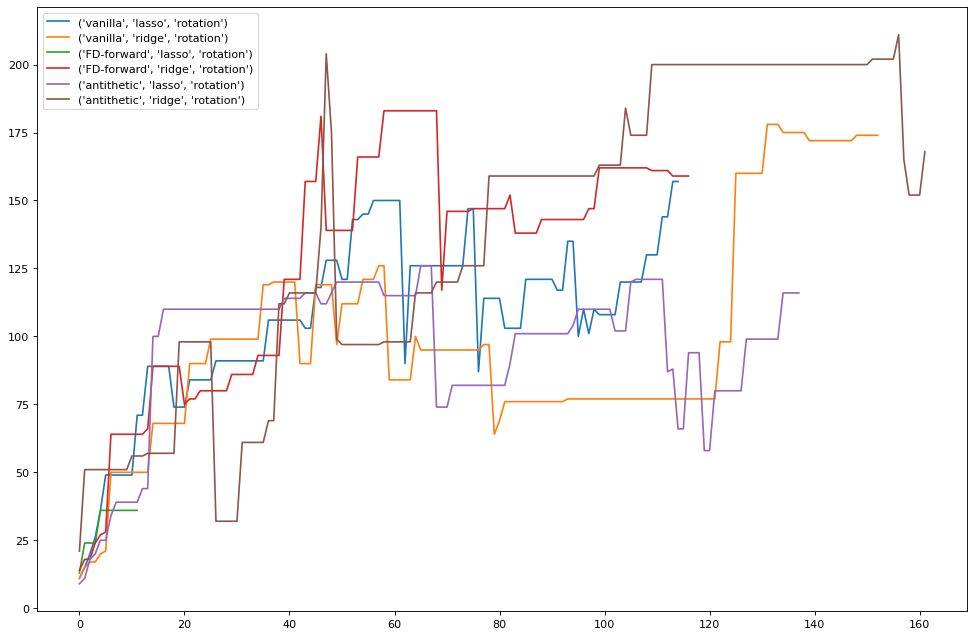

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(15, 10), dpi=80)
for i in outcome:
    plt.plot(np.arange(len(outcome[i])),outcome[i],label = i)
plt.legend()
plt.show()

In [ ]:
# show the video of the final result.
env = gym.make('CartPole-v0').env
while True:
    env.seed(0)
    s = env.reset()
    for a in A:
        env.render()
        s, _, done, _ = env.step(a)

        if done: break

KeyboardInterrupt: 